In [3]:
import pandas as pd
import numpy as np
from glob import  glob
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import xarray as xr

In [4]:
target_time = pd.date_range('19910101','20201231',freq='d')
df_times = pd.DataFrame({'index': target_time}, index=target_time)
df_times = df_times.drop(index=df_times[(df_times.index.day==29) & (df_times.index.month==2)].index)

paths = glob('data/raw/*')

def fix_name(d):
    return d.split(':')[-1].replace('\n','')[1:]

In [5]:
n_total_days = len(df_times)
print(f"observações esperadas {n_total_days}")

observações esperadas 10950


In [6]:
dfs = list()
for p in paths:
    
    with open(p) as file:
        data = file.readlines()
        names = ['name', 'cod', 'lat', 'lon', 'alt', 'status', 'init_at', 'end_at', 'freq']
        values = [fix_name(d) for d in data[:9]]
        cfg = dict(zip(names, values))

    df = pd.read_csv(p, sep=';', na_values=['-9999.0','null'], skiprows=9)

    for name, value in cfg.items():
        df[name] = value
    
    df.index = pd.to_datetime(df['Data Medicao'].values)
    df = df.loc['1991-01-01':'2020-12-31']
    df = df.drop(index=df[(df.index.day==29) & (df.index.month==2)].index)
    df = df_times.combine_first(df)

    main_df = df[['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)']]

    total = len(main_df)
    total_nan = len(main_df) - len(main_df.dropna())
    percent_null = total_nan/total * 100
    
    df['percent_null'] = round(float(percent_null), 1)
    df = df.sort_values('index')

    if percent_null < 12:       

        assert len(df) == n_total_days
        dfs.append(df)  

In [7]:
sel_columns = [
    'Data Medicao', 
    'PRECIPITACAO TOTAL, DIARIO(mm)',
    'TEMPERATURA MAXIMA, DIARIA(°C)',
    'TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)',
    'TEMPERATURA MINIMA, DIARIA(°C)',
    'UMIDADE RELATIVA DO AR, MEDIA DIARIA(%)', 
    'cod', 
    'lat', 
    'lon', 
    'alt',
    'name',
    'percent_null'
]
rename_cols = {
    'Data Medicao':'datas', 
    'PRECIPITACAO TOTAL, DIARIO(mm)':'prec',
    'TEMPERATURA MAXIMA, DIARIA(°C)':'tmax',
    'TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)':'tmean',
    'TEMPERATURA MINIMA, DIARIA(°C)':'tmin',
    'UMIDADE RELATIVA DO AR, MEDIA DIARIA(%)':'ur', 
}
df_concat = pd.concat(dfs)
df_concat = df_concat.loc[:, sel_columns].rename(columns=rename_cols)
df_concat['day_of_year'] = np.nan
df_concat['p95'] = np.nan
df_concat['p90'] = np.nan
df_concat['mean'] = np.nan

In [8]:
codes = df_concat.cod.dropna().unique()
names = [df_concat[df_concat.cod==code].name.iloc[0] for code in codes]
lons = [float(df_concat[df_concat.cod==code].lon.iloc[0]) for code in codes]
lats = [float(df_concat[df_concat.cod==code].lat.iloc[0]) for code in codes]
alt = [float(df_concat[df_concat.cod==code].alt.iloc[0]) for code in codes]
percent_null = [float(df_concat[df_concat.cod==code].percent_null.iloc[0]) for code in codes]
cidades = pd.DataFrame(dict(names=names, lons=lons, lats=lats, alt=alt, percent_null=percent_null), index=codes)

In [9]:
cidades

,names,lons,lats,alt,percent_null
83942,CAXIAS DO SUL,-51.186389,-29.196111,750.16,7.0
83948,TORRES,-49.716667,-29.350278,4.66,7.2
83964,ENCRUZILHADA DO SUL,-52.524722,-30.543056,427.75,4.2
83967,PORTO ALEGRE,-51.174767,-30.053611,41.18,2.7
83980,BAGE,-54.119444,-31.305556,245.66,1.3
83985,PELOTAS,-52.416667,-31.783333,13.00,7.9
83997,SANTA VITORIA DO PALMAR,-53.350278,-33.531667,24.01,0.6
83842,CURITIBA,-49.230556,-25.448611,923.50,1.8
83897,FLORIANOPOLIS,-48.620278,-27.602500,4.64,10.0
83766,LONDRINA,-51.141667,-23.325556,566.00,8.7


In [10]:
assert len(df_concat) == len(cidades) * n_total_days

In [12]:
# correction year_of_day because we ignoring 02/29 when is leapyear
for i in tqdm(range(len(df_concat))):
    
    index = df_concat.index[i]
    assert isinstance(index, pd.Timestamp)
    
    day_of_year = index.day_of_year
    is_leap_year = calendar.isleap(index.year)
    
    if is_leap_year:
        if day_of_year >= 60:
            day_of_year -= 1

    df_concat.loc[index, 'day_of_year'] = int(day_of_year)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 197100/197100 [01:19<00:00, 2464.03it/s]


In [13]:
df_clim = list()
df_done = list()
for code in codes:
    df_sel = df_concat[df_concat.cod==code].copy()

    try:
        assert len(df_sel) == n_total_days
    except:
        df_sel = df_times.combine_first(df_sel)
    
    days = df_sel.day_of_year.dropna().unique()
    _df = pd.DataFrame()
    _df['mean'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).mean()
    _df['p90'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).quantile(0.9)
    _df['p95'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).quantile(0.95)
    _df['code'] = code

    for day in days:
        df_sel.loc[df_sel.day_of_year==day, 'mean'] = _df.loc[day, 'mean']
        df_sel.loc[df_sel.day_of_year==day, 'p90'] = _df.loc[day, 'p90']
        df_sel.loc[df_sel.day_of_year==day, 'p95'] = _df.loc[day, 'p95']

    assert len(df_sel) == n_total_days
    
    df_done.append(df_sel)
    df_clim.append(_df)
    
df_clim = pd.concat(df_clim).reset_index()
df_done = pd.concat(df_done)

df_done['anom_p95'] = df_done['tmax'] - df_done['p95']
df_done['anom_p90'] = df_done['tmax'] - df_done['p90']
df_done['anom_mean'] = df_done['tmean'] - df_done['mean']

In [14]:
assert len(df_done) == 18 * n_total_days

In [15]:
assert len(df_clim) == 18 * 365

In [197]:
def extract(codes, df_done, variable, fill_with_nans=True):
    dfs = list()
    for i, code in tqdm(enumerate(codes)):
        
        df_code = df_done[df_done['cod']==code]
        df_code = df_times.combine_first(df_code)
        
        info = df_code.loc[:, ['name', 'cod', 'lat', 'lon', 'alt']]

        if fill_with_nans:
            df_code[variable] = df_code[variable].fillna(df_code[variable].mean())
        
        #df_final = pd.concat([info, df_code[variable]], axis=1).reset_index()
        
        _df = pd.DataFrame({code:df_code[variable].values}, index=df_code['index']).T
        dfs.append(_df)

    print(df.values.shape)
    print(df.values.ravel().shape)
    
    data2group = pd.DataFrame(
        [
            df.values.ravel() for df in dfs
        ], 
        columns=[str(c).split(' ')[0] for c in _df.columns], 
        index=[str(df.index[0]) for df in dfs]
    )
    
    data = data2group.reset_index()    
    data.index = data['index']
    data = data.drop(columns=['index'])
    return data

In [16]:
# dfs = list()
# for i, code in enumerate(codes):
#     df_code = df_done[df_done['cod']==code]
#     df_code = df_times.combine_first(df_code)
#     info = df_code.loc[:, ['name', 'cod', 'lat', 'lon', 'alt']]
    
#     df_code['anom_mean'] = df_code['anom_mean'].fillna(df_code['anom_mean'].mean())
    
#     df_final = pd.concat([info, df_code['anom_mean']], axis=1).reset_index()
    
#     _df = pd.DataFrame({code:df_final['anom_mean'].values}, index=df_final['index']).T
#     dfs.append(_df)


# data2group = pd.DataFrame([df.values.ravel() for df in dfs], columns=[str(c).split(' ')[0] for c in _df.columns], index=[str(df.index[0]) for df in dfs])
# data2group = data2group.reset_index()
# idx2code = data2group['index'].to_dict()

# data = data2group.iloc[:, :]
# data.index = data['index']
# data = data.drop(columns=['index'])

In [162]:
data = extract(codes, df_done, variable='anom_mean')

18it [00:00, 23.88it/s]


(10950, 22)
(240900,)


In [163]:
assert data.shape[0] == len(cidades)
assert data.shape[1] == n_total_days

In [164]:
data

,1991-01-01,1991-01-02,1991-01-03,1991-01-04,1991-01-05,1991-01-06,1991-01-07,1991-01-08,1991-01-09,1991-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
index,,,,,,,,,,,,,,,,,,,,,
83942,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,...,-3.217241e+00,-4.137931e-01,1.968966e+00,-1.310345e-01,7.931034e-02,-6.965517e-01,-6.586207e-01,1.128571e+00,3.272414e+00,-6.551724e-01
83948,-1.096667e+00,-4.633333e-01,1.333333e-02,-1.833333e-01,-6.466667e-01,-1.373333e+00,-1.063333e+00,-1.846667e+00,-2.816667e+00,-3.566667e+00,...,-2.313333e+00,-1.200000e-01,1.568966e+00,9.103448e-01,2.310345e-01,6.689655e-01,8.000000e-01,7.862069e-01,1.382759e+00,1.034483e-01
83964,8.517241e-01,1.068966e+00,-1.548276e+00,-3.072414e+00,-2.793103e+00,-9.655172e-01,2.482759e-01,1.386207e+00,1.934483e+00,-2.344828e-01,...,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16
83967,-5.413793e-01,1.579310e+00,-8.206897e-01,-2.727586e+00,-2.713793e+00,-1.768966e+00,-6.068966e-01,2.793103e-01,1.672414e+00,-1.286207e+00,...,-3.048276e+00,-8.862069e-01,1.434483e+00,4.500000e-01,8.666667e-02,-7.000000e-02,5.166667e-01,1.293333e+00,3.020690e+00,-9.344828e-01
83980,1.996667e+00,1.536667e+00,-4.200000e-01,-2.493333e+00,-2.260000e+00,1.800000e-01,2.083333e+00,3.480000e+00,1.226667e+00,6.266667e-01,...,-2.844828e+00,-1.241379e-01,3.093103e+00,1.610345e+00,5.206897e-01,-3.724138e-01,1.072414e+00,1.250000e+00,1.633333e-01,-3.941379e+00
83985,9.034483e-01,1.386207e+00,-1.258621e+00,-2.872414e+00,-2.455172e+00,-1.313793e+00,6.206897e-02,4.965517e-01,1.127586e+00,-5.655172e-01,...,-3.021429e+00,-1.196429e+00,1.303571e+00,2.392857e-01,1.071429e-01,1.028571e+00,2.428571e-01,2.250000e-01,1.903571e+00,-2.270370e+00
83997,1.313333e+00,3.000000e-02,-1.876667e+00,-1.846667e+00,-1.940000e+00,-1.676667e+00,-4.133333e-01,6.900000e-01,-2.100000e-01,-3.533333e-01,...,-3.473333e+00,-3.833333e-01,1.153333e+00,1.160000e+00,8.666667e-01,-4.179663e-17,4.100000e-01,1.503333e+00,2.530000e+00,-2.816667e+00
83842,-3.586207e+00,-1.224138e+00,-7.034483e-01,-1.717241e+00,-3.941379e+00,-3.596552e+00,-2.824138e+00,-1.562069e+00,-8.310345e-01,-5.103448e-01,...,-1.827586e+00,-9.000000e-01,-1.936667e+00,-1.806667e+00,-1.493333e+00,-4.227848e-17,1.033333e-01,1.931034e-01,2.575862e+00,8.166667e-01
83897,-2.966667e+00,-2.592593e-01,-1.518519e-01,-1.825926e+00,-2.103704e+00,-2.564286e+00,-1.870370e+00,-4.285714e-01,-4.678571e-01,3.428571e-01,...,-2.306489e-17,-2.306489e-17,-2.306489e-17,-2.306489e-17,-2.306489e-17,-2.306489e-17,-2.306489e-17,-2.306489e-17,-2.306489e-17,-2.306489e-17


In [165]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Dendograma')
        plt.xlabel('Estações')
        plt.ylabel('Distâncias')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.4g" % round(y,0), (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

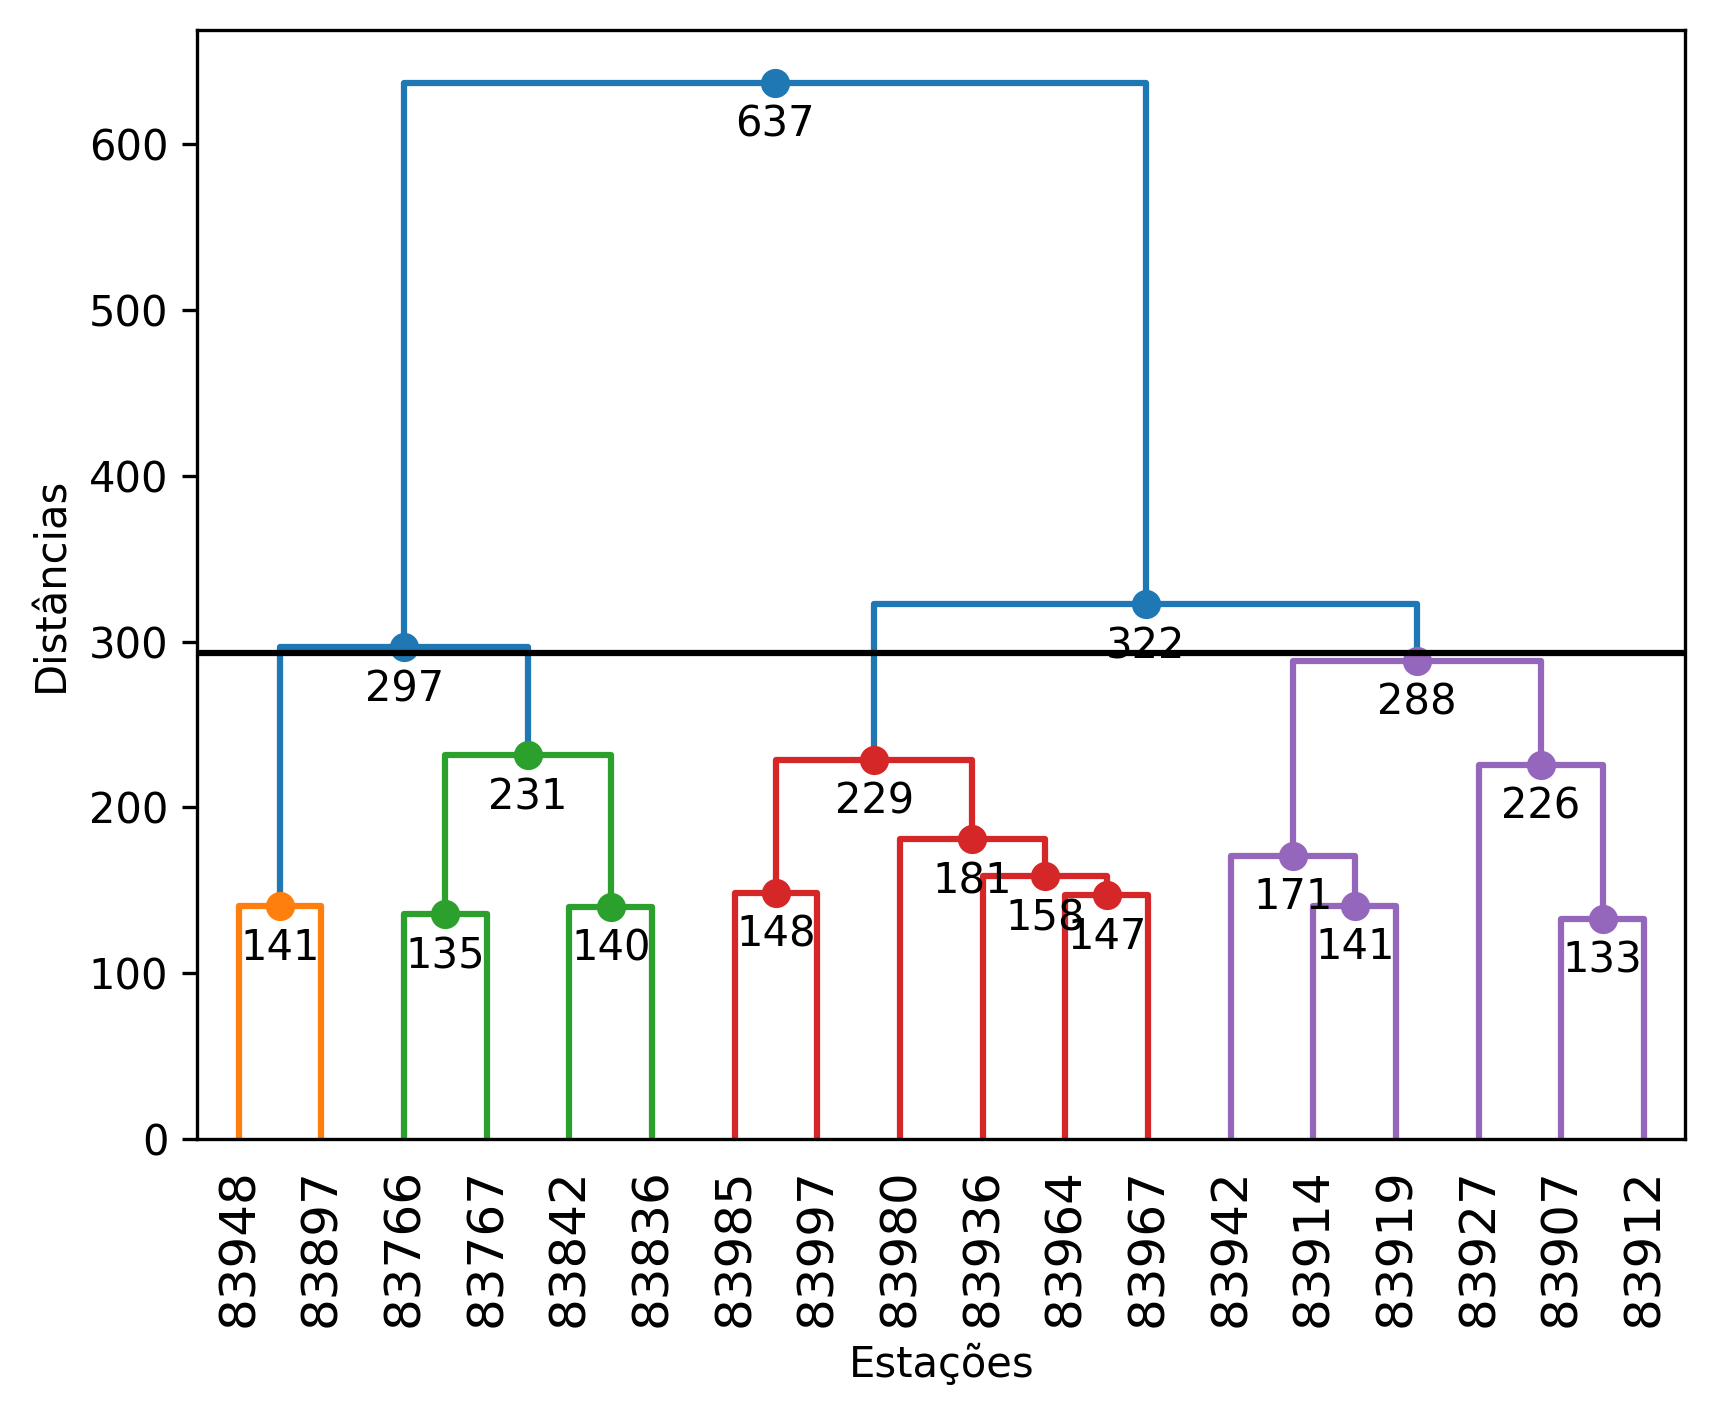

In [166]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

labels = list(data.index)
max_d = 293
Z = linkage(pdist(data.values), 'ward')
clusters = fcluster(Z,max_d,criterion='distance')

fig = plt.figure(dpi=300)
D = fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
    labels=labels,
)
plt.savefig('dendogram_ward.png')
plt.show()

In [167]:
codes2group = dict(zip(
    D['ivl'], 
    [c.replace('C','G') for c in D['leaves_color_list']]
))
group2color = {'G1': 'orange', 'G2': 'green', 'G3': 'red', 'G4': 'purple'}

def get_groups(group):
    return [k for k, v in codes2group.items() if v == group]


groups_ward = data.copy()
groups_ward.insert(0, 'labels', [c.replace('C','G') for c in D['leaves_color_list']])
groups_ward = groups_ward.groupby('labels').mean().T
groups_ward.index = pd.to_datetime(groups_ward.index)

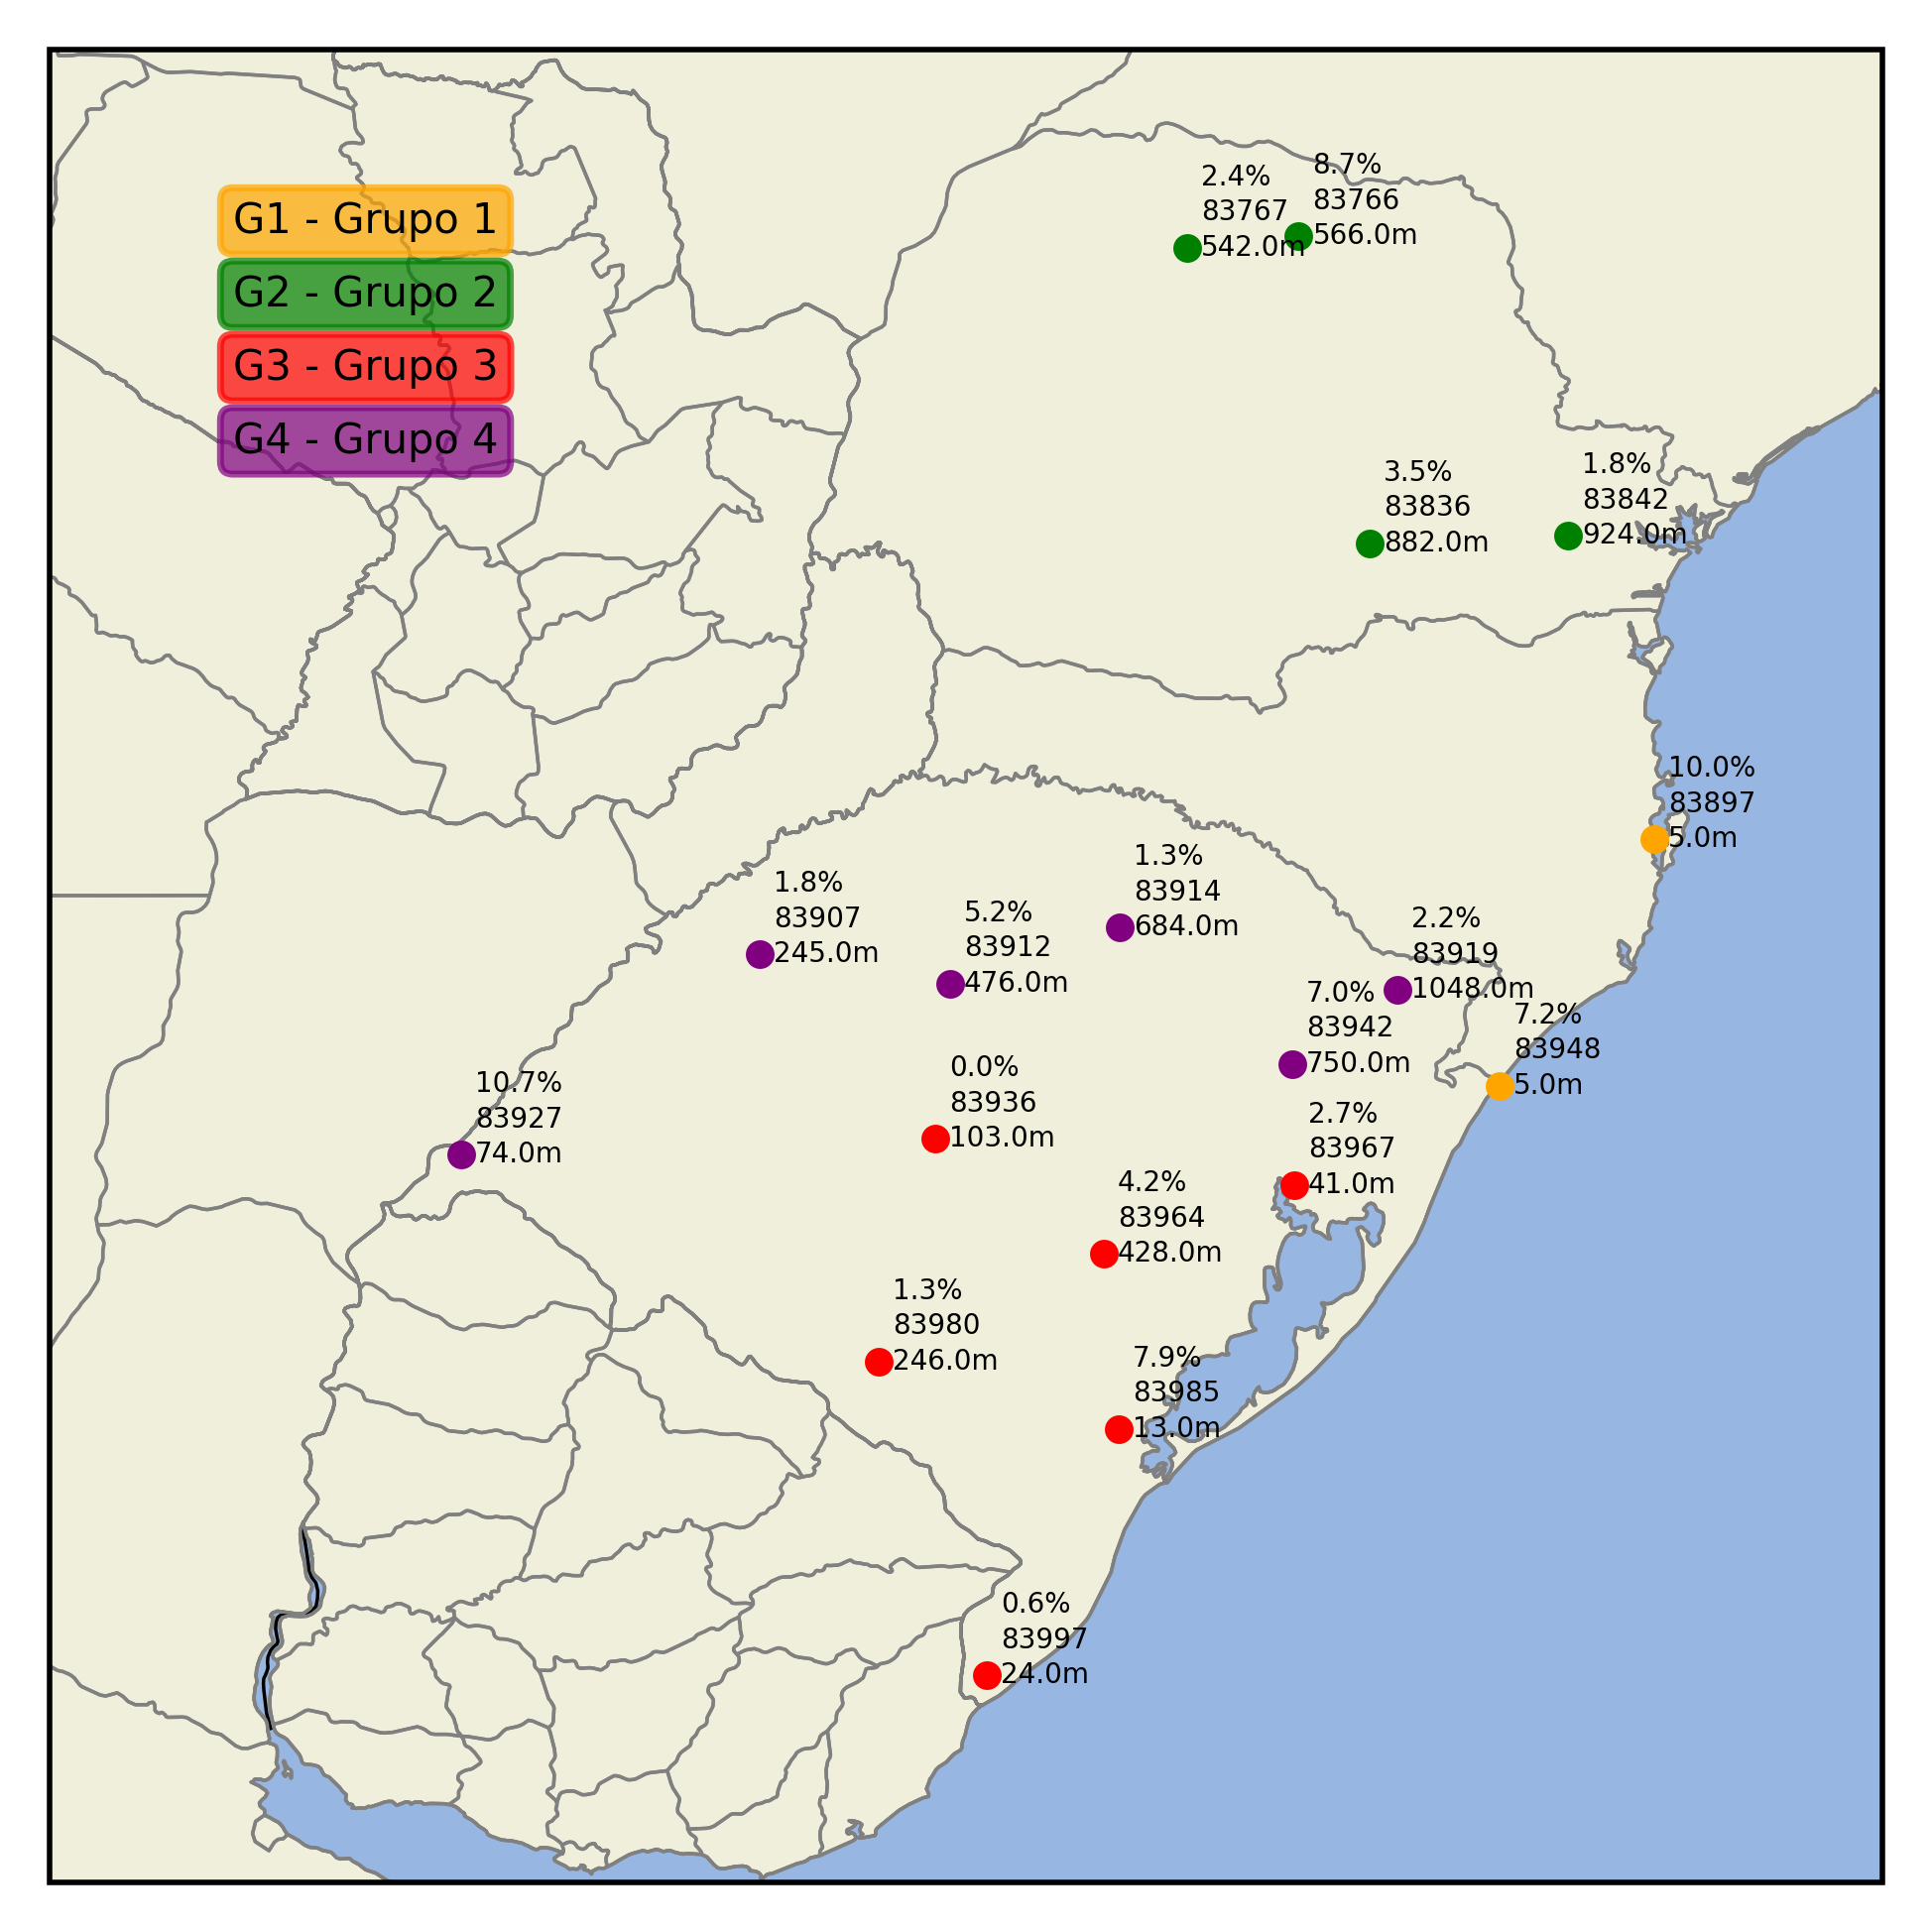

In [168]:
fig = plt.figure(dpi=500)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-60, -47, -35, -22], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple'}

x, y = 0.1, 0.9
for group, color in group_colors.items():
    ax.annotate(group, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor=color, edgecolor=color, boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.04  # Movendo para baixo para o próximo grupo

marker = 'o'
for code, row in cidades.iterrows():
    
    color = group2color.get(codes2group.get(code))
        
    ax.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
          color=color, s=10, zorder=5, marker=marker)
    ax.text(row['lons']+0.1, row['lats']+0., str(round(row['alt'],0)) + 'm',
            transform=ccrs.PlateCarree(),
            fontsize=4, 
            color='black', zorder=100,
            verticalalignment='center')
    ax.text(row['lons']+0.1, row['lats']+0.5, str(row['percent_null']) + '%',
            transform=ccrs.PlateCarree(),
            fontsize=4, 
            color='black', zorder=100,
            verticalalignment='center')
    ax.text(row['lons']+0.1, row['lats']+0.25, code,
            transform=ccrs.PlateCarree(),
            fontsize=4,
            color='black', zorder=100,
            verticalalignment='center')

plt.savefig('stations_ward.png')
plt.show()

/tmp/ipykernel_1811062/3491154047.py:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  values_ward = groups_ward.resample('3m').mean()


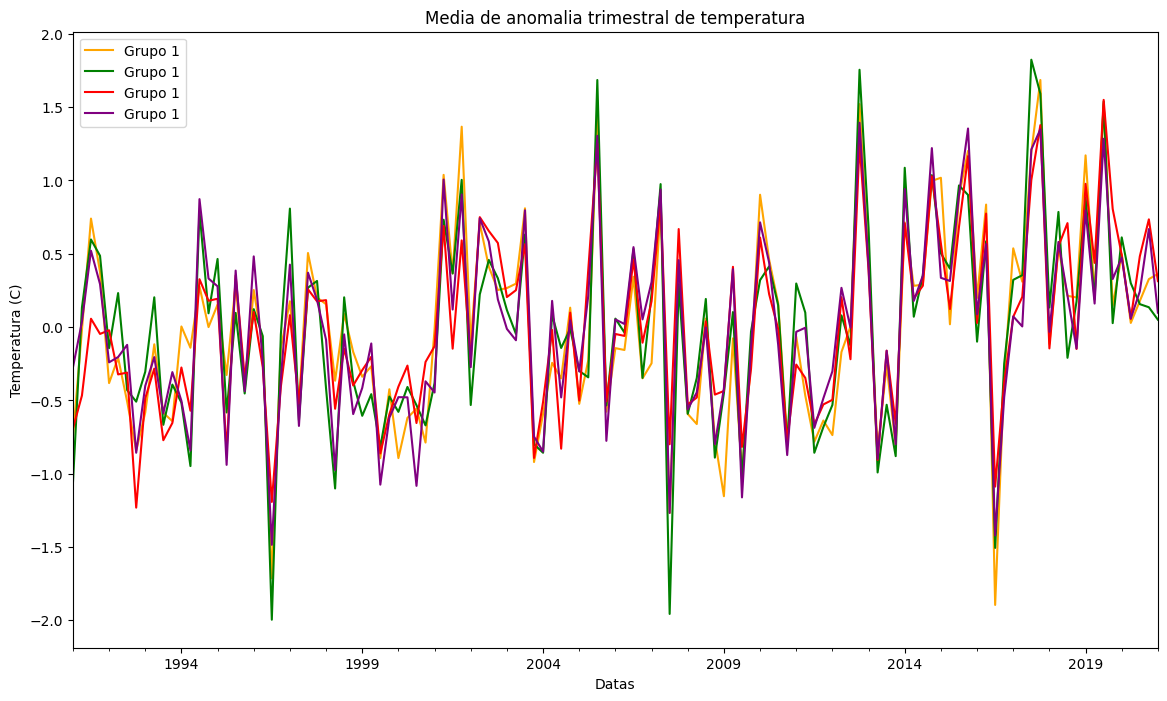

In [169]:
fig, ax = plt.subplots(1,1, figsize=(16,12), sharey=True, sharex=True)
values_ward = groups_ward.resample('3m').mean()
values_ward['G1'].plot(ax=ax, alpha=1, subplots=False, figsize=(14,8), ylabel='Temperatura (C)', xlabel='Datas', label='Grupo 1', color=group2color.get('G1'))
values_ward['G2'].plot(ax=ax, alpha=1, subplots=False, figsize=(14,8), ylabel='Temperatura (C)', xlabel='Datas', label='Grupo 1', color=group2color.get('G2'))
values_ward['G3'].plot(ax=ax, alpha=1, subplots=False, figsize=(14,8), ylabel='Temperatura (C)', xlabel='Datas', label='Grupo 1', color=group2color.get('G3'))
values_ward['G4'].plot(ax=ax, alpha=1, subplots=False, figsize=(14,8), ylabel='Temperatura (C)', xlabel='Datas', label='Grupo 1', color=group2color.get('G4'))
ax.legend()
plt.title('Media de anomalia trimestral de temperatura')
plt.savefig('groups_temperature_seasonal_ward.png')

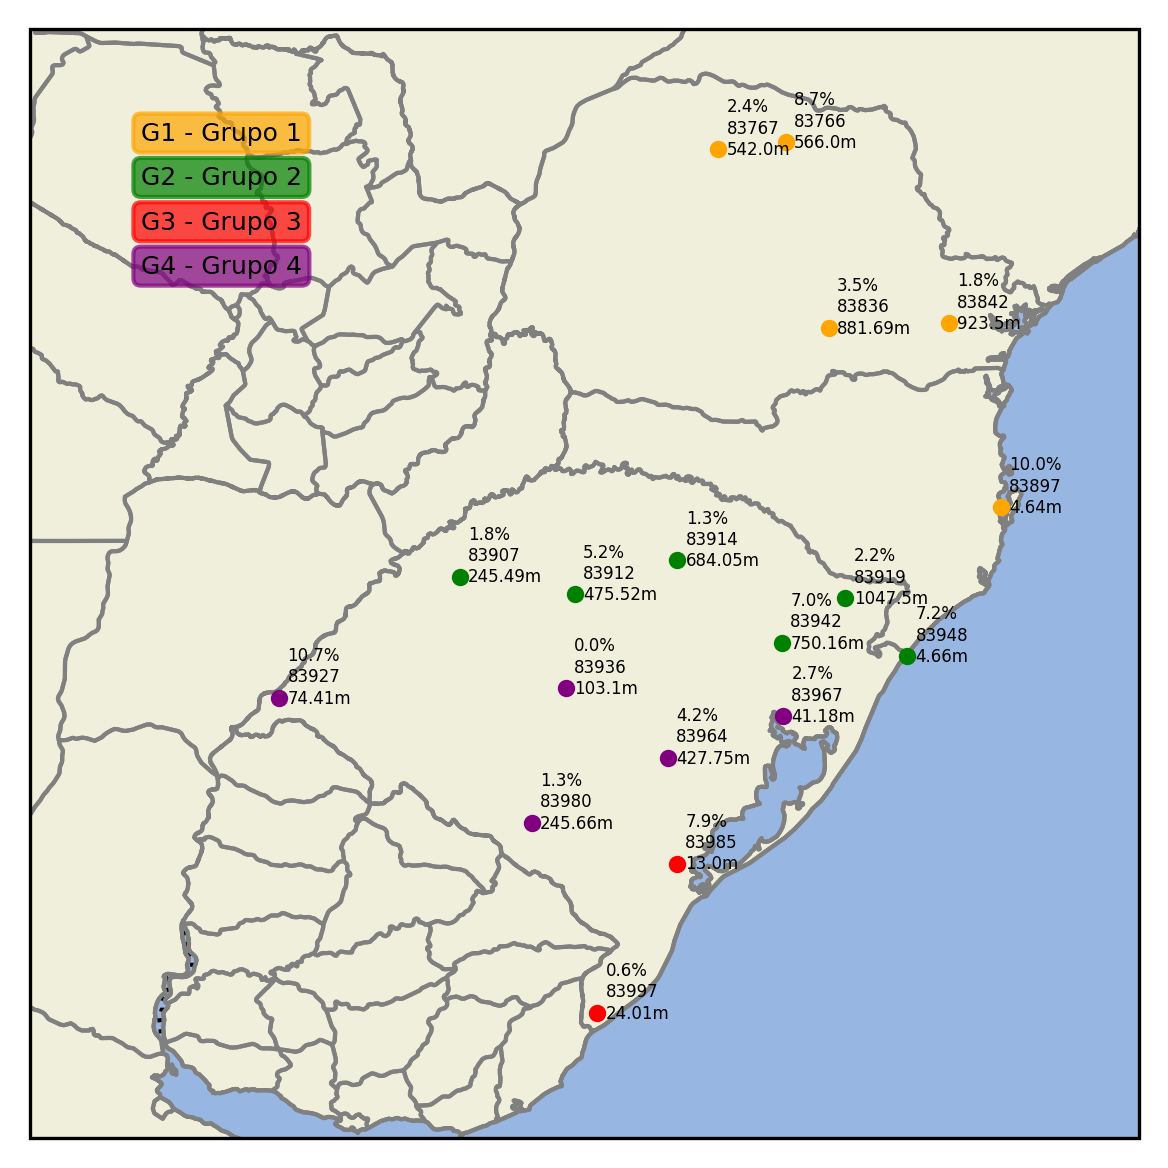

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import KMeans

# Aplicação do KMeans
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(data.values)
labels = [f"G{int(l+1)}" for l in kmeans.labels_]
code2group = dict(zip(data.index, labels))

groups_kmeans = data.copy()
groups_kmeans.insert(0, 'labels', labels)
groups_kmeans = groups_kmeans.groupby('labels').mean().T
groups_kmeans.index = pd.to_datetime(groups_kmeans.index)

fig = plt.figure(dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-60, -47, -35, -22], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN, edgecolor='gray')
ax.add_feature(cfeature.STATES, edgecolor='gray')

x, y = 0.1, 0.9
for group, color in group_colors.items():
    ax.annotate(group, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor=color, edgecolor=color, boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.04  # Movendo para baixo para o próximo grupo


scatters = []
for code, row in cidades.iterrows():
    label = code2group.get(code)
    color = group2color.get(label)
    
    scatter = ax.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
                         color=color, s=10, zorder=5, marker='o')
    
    ax.text(row['lons']+0.1, row['lats']+0., str(round(row['alt'],3)) + 'm',
            transform=ccrs.PlateCarree(),
            fontsize=4, 
            color='black', zorder=100,
            verticalalignment='center')
    ax.text(row['lons']+0.1, row['lats']+0.5, str(row['percent_null']) + '%',
            transform=ccrs.PlateCarree(),
            fontsize=4, 
            color='black', zorder=100,
            verticalalignment='center')
    ax.text(row['lons']+0.1, row['lats']+0.25, code,
            transform=ccrs.PlateCarree(),
            fontsize=4,
            color='black', zorder=100,
            verticalalignment='center')

# Salvamento e exibição da imagem
plt.savefig('stations_kmeans.png')
plt.show()

/tmp/ipykernel_1811062/752090383.py:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  values_kmeans = groups_kmeans.resample('3m').mean()


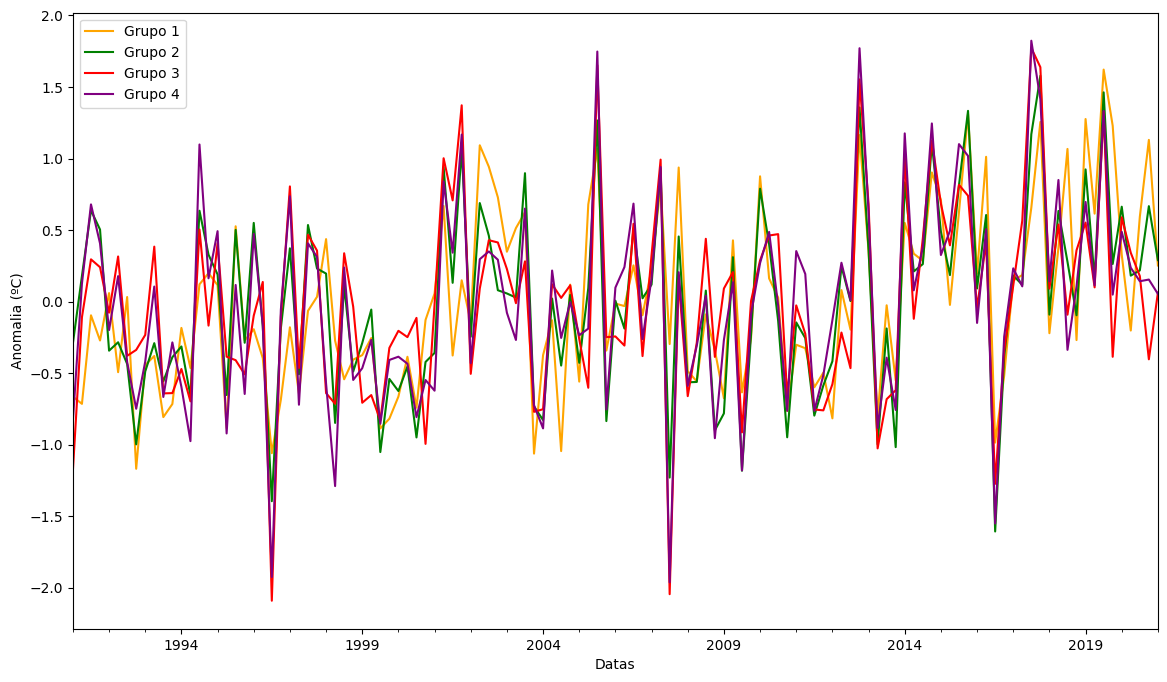

In [171]:
fig, ax = plt.subplots(1,1, figsize=(16,12), sharey=True, sharex=True)
values_kmeans = groups_kmeans.resample('3m').mean()
values_kmeans['G1'].plot(ax=ax, alpha=1, subplots=False, figsize=(14,8), ylabel='Anomalia (ºC)', xlabel='Datas', label='Grupo 1', color=group2color.get('G1'))
values_kmeans['G2'].plot(ax=ax, alpha=1, subplots=False, figsize=(14,8), ylabel='Anomalia (ºC)', xlabel='Datas', label='Grupo 2', color=group2color.get('G2'))
values_kmeans['G3'].plot(ax=ax, alpha=1, subplots=False, figsize=(14,8), ylabel='Anomalia (ºC)', xlabel='Datas', label='Grupo 3', color=group2color.get('G3'))
values_kmeans['G4'].plot(ax=ax, alpha=1, subplots=False, figsize=(14,8), ylabel='Anomalia (ºC)', xlabel='Datas', label='Grupo 4', color=group2color.get('G4'))
ax.legend()
plt.savefig('groups_temperature_seasonal_kmeans.png')

In [124]:
df_done

,datas,prec,tmax,tmean,tmin,ur,cod,lat,lon,alt,...,percent_null,day_of_year,p95,p90,mean,index,anom_p95,anom_p90,anom_mean,labels
1991-01-01,1991-01-01,0.0,NaN,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,...,7.0,1.0,24.50,23.94,21.344000,NaT,NaN,NaN,NaN,G2
1991-01-02,1991-01-02,0.0,28.7,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,...,7.0,2.0,24.38,23.86,20.712000,NaT,4.32,4.84,NaN,G2
1991-01-03,1991-01-03,0.0,24.6,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,...,7.0,3.0,23.70,23.66,20.640000,NaT,0.90,0.94,NaN,G2
1991-01-04,1991-01-04,0.0,24.0,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,...,7.0,4.0,23.88,23.56,20.992000,NaT,0.12,0.44,NaN,G2
1991-01-05,1991-01-05,0.0,26.4,NaN,NaN,NaN,83942,-29.1961111,-51.18638888,750.16,...,7.0,5.0,24.68,24.12,21.688000,NaT,1.72,2.28,NaN,G2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2020-12-27,0.0,27.8,21.2,17.0,79.3,83836,-25.50277777,-50.63749999,881.69,...,3.5,361.0,24.78,23.64,21.431034,NaT,3.02,4.16,-0.231034,G1
2020-12-28,2020-12-28,0.0,28.1,21.4,16.9,85.5,83836,-25.50277777,-50.63749999,881.69,...,3.5,362.0,23.30,23.06,21.396552,NaT,4.80,5.04,0.003448,G1
2020-12-29,2020-12-29,0.6,26.6,20.9,17.5,89.3,83836,-25.50277777,-50.63749999,881.69,...,3.5,363.0,23.60,23.22,21.579310,NaT,3.00,3.38,-0.679310,G1
2020-12-30,2020-12-30,1.5,29.8,23.3,16.8,77.3,83836,-25.50277777,-50.63749999,881.69,...,3.5,364.0,23.60,23.30,21.644828,NaT,6.20,6.50,1.655172,G1


In [266]:
anom_mean = extract(codes, df_done, variable='anom_mean', fill_with_nans=False)
tmean = extract(codes, df_done, variable='tmean', fill_with_nans=False)
mean = extract(codes, df_done, variable='mean', fill_with_nans=False)

teste = tmean.loc['83936'] - mean.loc['83936'] == anom_mean.loc['83936'].values

18it [00:00, 22.35it/s]


(10950, 22)
(240900,)


18it [00:00, 22.92it/s]


(10950, 22)
(240900,)


18it [00:00, 23.13it/s]


(10950, 22)
(240900,)


In [267]:
tmean

,1991-01-01,1991-01-02,1991-01-03,1991-01-04,1991-01-05,1991-01-06,1991-01-07,1991-01-08,1991-01-09,1991-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
index,,,,,,,,,,,,,,,,,,,,,
83942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.8,20.3,22.6,21.0,21.8,20.8,20.8,23.0,25.3,21.0
83948,22.5,23.0,23.3,23.1,22.8,22.4,22.8,22.5,21.2,20.2,...,21.0,23.2,24.4,24.0,23.9,24.0,24.3,24.6,25.3,24.1
83964,23.2,23.4,20.4,19.5,20.1,22.1,23.3,24.6,25.2,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83967,24.1,26.2,23.2,21.9,22.3,23.5,24.6,25.8,27.3,24.1,...,21.5,23.5,25.5,25.2,25.1,24.7,25.4,26.4,28.8,24.0
83980,25.3,25.0,22.6,21.3,21.8,24.3,25.9,27.9,26.1,24.7,...,20.1,22.8,26.2,25.7,24.3,23.7,25.2,25.7,24.5,19.7
83985,23.8,24.3,21.3,20.3,21.0,22.2,23.6,24.3,25.5,23.6,...,19.3,21.1,24.0,23.8,23.6,24.6,23.9,23.8,25.8,20.8
83997,23.3,21.8,20.0,20.7,20.8,21.1,22.3,23.6,22.9,22.5,...,17.8,20.8,22.9,23.4,23.1,NaN,22.9,24.2,24.9,19.2
83842,17.6,20.0,20.0,19.0,17.3,17.7,18.4,19.7,20.8,20.7,...,19.3,19.8,19.0,19.0,19.6,NaN,21.6,21.7,24.4,22.9
83897,22.1,24.6,24.6,22.8,22.9,22.8,23.5,25.1,24.9,25.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [268]:
564/10386 * 100

5.430387059503177

In [269]:
test[test==True]

1991-01-01    True
1991-01-02    True
1991-01-03    True
1991-01-04    True
1991-01-05    True
              ... 
2020-12-26    True
2020-12-28    True
2020-12-29    True
2020-12-30    True
2020-12-31    True
Name: 83912, Length: 10386, dtype: bool

In [270]:
test[test.values==False]

1993-08-19    False
1996-06-07    False
2001-01-18    False
2001-01-19    False
2001-01-20    False
              ...  
2020-11-29    False
2020-12-06    False
2020-12-13    False
2020-12-20    False
2020-12-27    False
Name: 83912, Length: 564, dtype: bool

In [271]:
tmean.loc['83912','1993-08-19']

np.float64(nan)

In [272]:
tmean.loc['83912','1991-01-01']

np.float64(24.6)

In [275]:
assert tmean.loc['83912','1991-01-01'] - mean.loc['83912','1991-01-01']  == anom_mean.loc['83912','1991-01-01']

In [276]:
tmean_groups = pd.DataFrame({'G1':tmean.T[get_groups('G1')].mean(axis=1), 
                             'G2':tmean.T[get_groups('G2')].mean(axis=1), 
                             'G3':tmean.T[get_groups('G3')].mean(axis=1), 
                             'G4':tmean.T[get_groups('G4')].mean(axis=1)})

mean_groups = pd.DataFrame({'G1':mean.T[get_groups('G1')].mean(axis=1), 
                             'G2':mean.T[get_groups('G2')].mean(axis=1), 
                             'G3':mean.T[get_groups('G3')].mean(axis=1), 
                             'G4':mean.T[get_groups('G4')].mean(axis=1)})

anom_mean_groups = pd.DataFrame({'G1':anom_mean.T[get_groups('G1')].mean(axis=1), 
                             'G2':anom_mean.T[get_groups('G2')].mean(axis=1), 
                             'G3':anom_mean.T[get_groups('G3')].mean(axis=1), 
                             'G4':anom_mean.T[get_groups('G4')].mean(axis=1)})

In [278]:
get_groups('G1')

['83948', '83897']

In [282]:
tmean

,1991-01-01,1991-01-02,1991-01-03,1991-01-04,1991-01-05,1991-01-06,1991-01-07,1991-01-08,1991-01-09,1991-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
index,,,,,,,,,,,,,,,,,,,,,
83942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.8,20.3,22.6,21.0,21.8,20.8,20.8,23.0,25.3,21.0
83948,22.5,23.0,23.3,23.1,22.8,22.4,22.8,22.5,21.2,20.2,...,21.0,23.2,24.4,24.0,23.9,24.0,24.3,24.6,25.3,24.1
83964,23.2,23.4,20.4,19.5,20.1,22.1,23.3,24.6,25.2,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83967,24.1,26.2,23.2,21.9,22.3,23.5,24.6,25.8,27.3,24.1,...,21.5,23.5,25.5,25.2,25.1,24.7,25.4,26.4,28.8,24.0
83980,25.3,25.0,22.6,21.3,21.8,24.3,25.9,27.9,26.1,24.7,...,20.1,22.8,26.2,25.7,24.3,23.7,25.2,25.7,24.5,19.7
83985,23.8,24.3,21.3,20.3,21.0,22.2,23.6,24.3,25.5,23.6,...,19.3,21.1,24.0,23.8,23.6,24.6,23.9,23.8,25.8,20.8
83997,23.3,21.8,20.0,20.7,20.8,21.1,22.3,23.6,22.9,22.5,...,17.8,20.8,22.9,23.4,23.1,NaN,22.9,24.2,24.9,19.2
83842,17.6,20.0,20.0,19.0,17.3,17.7,18.4,19.7,20.8,20.7,...,19.3,19.8,19.0,19.0,19.6,NaN,21.6,21.7,24.4,22.9
83897,22.1,24.6,24.6,22.8,22.9,22.8,23.5,25.1,24.9,25.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [253]:
tmean_groups

,G1,G2,G3,G4
1991-01-01,22.30,21.250000,24.350000,23.620000
1991-01-02,23.80,22.100000,24.583333,26.200000
1991-01-03,23.95,20.766667,22.083333,25.500000
1991-01-04,22.95,21.566667,20.983333,22.933333
1991-01-05,22.85,20.366667,21.516667,24.600000
...,...,...,...,...
2020-12-27,24.00,23.333333,24.500000,21.875000
2020-12-28,24.30,23.525000,24.620000,21.820000
2020-12-29,24.60,22.000000,25.280000,23.620000
2020-12-30,25.30,24.325000,26.080000,24.560000


In [283]:
tmean_groups.to_csv('data/pos/tmean_groups_kmeans.csv')

In [284]:
mean_groups.to_csv('data/pos/tmean_clim_groups_kmeans.csv')

In [285]:
anom_mean_groups.to_csv('data/pos/tmean_anomaly_groups_kmeans.csv')

1991-03-24    False
1991-04-19    False
1991-12-24    False
1991-12-25    False
1991-12-26    False
              ...  
2020-11-06    False
2020-11-07    False
2020-11-08    False
2020-11-09    False
2020-11-10    False
Name: 83948, Length: 791, dtype: bool

In [205]:
test[test.values==True]

1991-01-01    True
1991-01-02    True
1991-01-03    True
1991-01-04    True
1991-01-05    True
              ... 
2020-12-27    True
2020-12-28    True
2020-12-29    True
2020-12-30    True
2020-12-31    True
Name: 83948, Length: 10159, dtype: bool

In [207]:
tmean.loc['83948', '1991-03-24']

np.float64(nan)

In [193]:
tmean.loc['83948', '1991-03-24']

np.float64(19.62153755290875)

In [194]:
anom_mean.loc['83948', '1991-03-24']

np.float64(2.2381501667805104e-17)

In [195]:
19.62153755290875 - 22.96

-3.338462447091249